<a href="https://colab.research.google.com/github/saytech03/Disease_Detection/blob/main/Medical_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pennylane scikit-learn matplotlib numpy qiskit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 52.6 MB/s eta 0:00:00


Epoch 1: Cost = 0.1177
Epoch 2: Cost = 0.1175
Epoch 3: Cost = 0.1173
Epoch 4: Cost = 0.1171
Epoch 5: Cost = 0.1167
Epoch 6: Cost = 0.1161
Epoch 7: Cost = 0.1155
Epoch 8: Cost = 0.1147
Epoch 9: Cost = 0.1139
Epoch 10: Cost = 0.1132
Epoch 11: Cost = 0.1125
Epoch 12: Cost = 0.1118
Epoch 13: Cost = 0.1113
Epoch 14: Cost = 0.1108
Epoch 15: Cost = 0.1104
Epoch 16: Cost = 0.1100
Epoch 17: Cost = 0.1097
Epoch 18: Cost = 0.1094
Epoch 19: Cost = 0.1092
Epoch 20: Cost = 0.1090
Epoch 21: Cost = 0.1088
Epoch 22: Cost = 0.1087
Epoch 23: Cost = 0.1085
Epoch 24: Cost = 0.1084
Epoch 25: Cost = 0.1083
Epoch 26: Cost = 0.1082
Epoch 27: Cost = 0.1082
Epoch 28: Cost = 0.1081
Epoch 29: Cost = 0.1081
Epoch 30: Cost = 0.1080


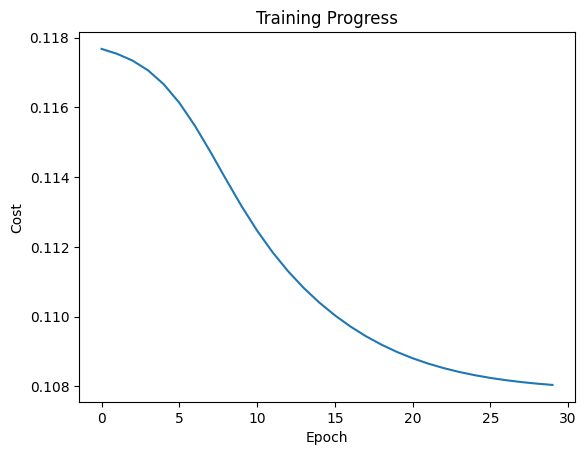

Training Accuracy: 0.87
Test Accuracy: 0.89


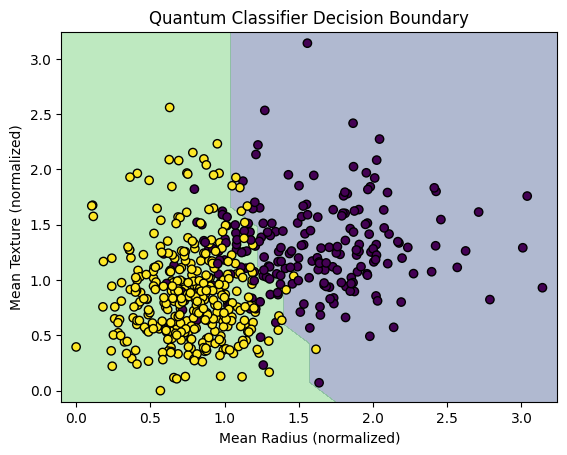

In [6]:
import pennylane as qml
from pennylane import numpy as np  # Must use PennyLane's numpy
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load and prepare the dataset
data = load_breast_cancer()
X = data.data
y = data.target.astype(float)  # Convert to float

# Select only 2 features for our 2-qubit system
X = X[:, [0, 1]]  # Using mean radius and mean texture

# Normalize features to [0, π] range for quantum encoding
scaler = MinMaxScaler(feature_range=(0, np.pi))
X = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Quantum circuit setup - 2 qubits
dev = qml.device("default.qubit", wires=2)

# Define the quantum circuit
@qml.qnode(dev)
def quantum_circuit(x, weights):
    # We need 4 weights for our circuit architecture
    # Encode the two features
    qml.RY(x[0], wires=0)
    qml.RY(x[1], wires=1)

    # Apply trainable gates
    qml.RY(weights[0], wires=0)
    qml.RY(weights[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(weights[2], wires=0)
    qml.RY(weights[3], wires=1)

    # Measurement
    return qml.expval(qml.PauliZ(0))

# Cost function
def cost(weights, X, y):
    predictions = np.array([quantum_circuit(x, weights) for x in X])
    return np.mean((predictions - y) ** 2)

# Initialize weights properly - need 4 weights for our circuit
weights = np.random.rand(4, requires_grad=True)  # Crucial: requires_grad=True

# Use PennyLane's optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.1)
batch_size = 5

# Training loop
cost_history = []
for epoch in range(30):
    # Update weights batch by batch
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        # The opt.step function returns a list containing the updated parameters.
        # We need to extract the actual updated weights array from this list.
        updated_weights_list = opt.step(cost, weights, X_batch, y_batch)
        weights = updated_weights_list[0] # Access the first (and only) element

    # Calculate and store cost
    current_cost = cost(weights, X_train, y_train)
    cost_history.append(float(current_cost))  # Convert to regular Python float
    print(f"Epoch {epoch+1}: Cost = {current_cost:.4f}")

# Plot training progress
plt.plot(cost_history)
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.title("Training Progress")
plt.show()

# Evaluation
def predict(X, weights, threshold=0.5):
    predictions = np.array([quantum_circuit(x, weights) for x in X])
    return (predictions > threshold).astype(int)

train_acc = np.mean(predict(X_train, weights) == y_train)
test_acc = np.mean(predict(X_test, weights) == y_test)

print(f"Training Accuracy: {train_acc:.2f}")
print(f"Test Accuracy: {test_acc:.2f}")

# Visualize decision boundary
def plot_decision_boundary():
    # Create a mesh grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 20),
                         np.linspace(y_min, y_max, 20))

    # Predict for each point
    # Ensure the input to quantum_circuit is a structure it can handle (e.g., a list or array)
    Z = np.array([quantum_circuit([x, y], weights) for x, y in zip(xx.ravel(), yy.ravel())])
    Z = (Z > 0.5).reshape(xx.shape)

    # Plot
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    plt.xlabel("Mean Radius (normalized)")
    plt.ylabel("Mean Texture (normalized)")
    plt.title("Quantum Classifier Decision Boundary")
    plt.show()

plot_decision_boundary()